In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model  # Update import statement
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout  # Update import statement
import matplotlib.pyplot as plt
import os
import pickle
from glob import glob
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random

In [39]:
FOLDER_IMAGES = './datasets/dmd/binary_labels'
INPUT_SHAPE = (180, 180, 3)
BATCH_SIZE = 32
IMG_SIZE = (180, 180)
VAL_SPLIT = 0.2
MODEL_SAVE_FOLDER = './models/cnn/cnn_simple/'

In [40]:
X = []
Y = []
for i in tqdm(glob(FOLDER_IMAGES + '/awake/*')):
    temp = np.array(Image.open(i).resize(IMG_SIZE))
    X.append(temp)
    Y.append(1)

for i in tqdm(glob(FOLDER_IMAGES + '/drowsy/*')):
    temp = np.array(Image.open(i).resize(IMG_SIZE))
    X.append(temp)
    Y.append(0)

X = np.array(X)
X = X / 255.0
Y = np.array(Y)
X = np.expand_dims(X, -1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

100%|██████████| 4742/4742 [00:34<00:00, 135.61it/s]


In [7]:
if os.path.exists(MODEL_SAVE_FOLDER):
    model = keras.models.load_model(MODEL_SAVE_FOLDER + 'best.h5')
else:
    model = keras.models.Sequential([
        Input(shape=INPUT_SHAPE),

        Conv2D(filters=32, kernel_size=5, strides=1, activation='relu'),
        Conv2D(filters=32, kernel_size=5, strides=1, activation='relu', use_bias=False),
        BatchNormalization(),
        MaxPooling2D(strides=2),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'),
        Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', use_bias=False),
        BatchNormalization(),
        MaxPooling2D(strides=2),
        Dropout(0.3),

        Flatten(),
        Dense(units=256, activation='relu', use_bias=False),
        BatchNormalization(),

        Dense(units=128, use_bias=False, activation='relu'),

        Dense(units=84, use_bias=False, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(units=1, activation='sigmoid')
    ])

    print(model.summary())

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3)

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=MODEL_SAVE_FOLDER + 'best.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        callbacks=[early_stop, model_checkpoint]
    )

    with open(MODEL_SAVE_FOLDER + 'model_history.pkl', 'wb') as file:
        pickle.dump(history.history, file)

with open(MODEL_SAVE_FOLDER + 'model_history.pkl', 'rb') as file:
    history = pickle.load(file)
    print(history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 176, 176, 32)      2432      
                                                                 
 conv2d_17 (Conv2D)          (None, 172, 172, 32)      25600     
                                                                 
 batch_normalization_16 (Bat  (None, 172, 172, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 86, 86, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 84, 84, 64)       

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (7018, 180, 180, 3, 1)

 46/176 [======>.......................] - ETA: 3:02 - loss: 0.4714 - accuracy: 0.7914

KeyboardInterrupt: 

In [37]:
best_model = load_model(MODEL_SAVE_FOLDER + 'best.h5')
best_model.evaluate(x_test, y_test)

ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (3458, 180, 180, 3, 1)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(MODEL_SAVE_FOLDER + 'best.tflite', 'wb') as f:
    f.write(tflite_model)

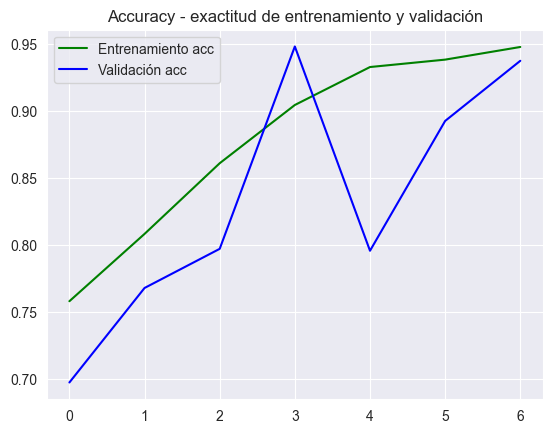

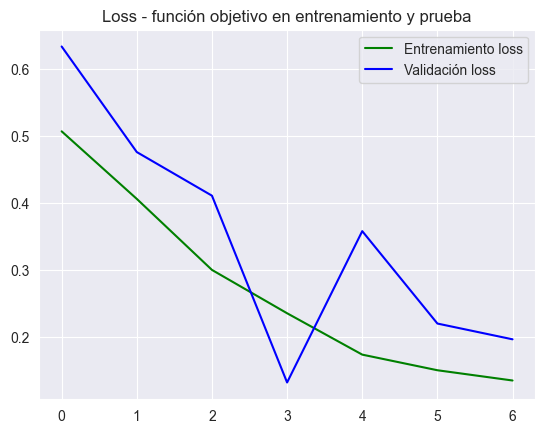

In [23]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Entrenamiento acc', color='green')
plt.plot(epochs, val_acc, label='Validación acc', color='blue')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()
plt.figure()

plt.plot(epochs, loss, color='green', label='Entrenamiento loss')
plt.plot(epochs, val_loss, color='blue', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [33]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#
# # Obtain predictions for the test data
# predictions = best_model.predict(x_test)
# predicted_labels = np.argmax(predictions, axis=1)
#
# # Select 5 random indices from the test dataset
# random_indices = random.sample(range(len(x_test)), 5)
#
# # Plot the random images and their predicted labels
# fig, axes = plt.subplots(1, 5, figsize=(15, 3))
# for i, ax in enumerate(axes):
#     image_index = random_indices[i]
#     image = x_test[image_index]
#     label = predicted_labels[image_index]
#     true_label = y_test[image_index]
#
#     ax.imshow(image, cmap='gray')
#     ax.set_title(f"Predicted: {label}\nTrue: {true_label}")
#     ax.axis('off')
#
# plt.tight_layout()
# plt.show()

for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i, 0))
    print(result)
    plt.imshow(i)
    plt.show()

    if result > 0.5:
        print('Awake')
    else:
        print("Drowsy")

ValueError: tf.enable_eager_execution must be called at program startup.

In [ ]:
plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")